In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
import pickle
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_csv('../data/raw/train_lofi_rowid_Nov13.csv')
df_test = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')
input_file_name = '/home/geoanton/Repos/gamma_log_classification/data/processed/train_nn_1.pck'
#with open(input_file_name, 'rb') as f:
        #results = pickle.load(f)
#df_train_cax = pd.read_csv('../data/raw/CAX_LogFacies_Train_File.csv')
#df_test_cax = pd.read_csv('../data/raw/CAX_LogFacies_Test_File.csv')
df_train.head()

row_id  well_id          GR  label
0       0        0   99.005617      0
1       1        0  105.563944      0
2       2        0  105.921065      0
3       3        0  113.513354      0
4       4        0  101.523783      0

In [74]:
fold=3
input_file_name = f'/home/geoanton/Repos/gamma_log_classification/data/processed/train_nn_{fold}.pck'
with open(input_file_name, 'rb') as f:
        results = pickle.load(f)
        
X, y = results[f'data_dict_train_{fold}']['X_fake_only'], results[f'data_dict_train_{fold}']['y_fake_only']
X_ho, y_ho = results[f'data_dict_test_{fold}']['X'], results[f'data_dict_test_{fold}']['y']
for k,v in results[f'data_dict_train_{fold}'].items():
    print(k,v.mean(),v.std())
print('Test')
for k,v in results[f'data_dict_test_{fold}'].items():
    print(k,v.mean(),v.std())


X 97.68696832491979 32.15696276568494
y 0.2 0.400000000000011
X_with_fake 97.68696832491977 32.15696276568492
y_with_fake 0.2 0.4000000000000288
X_fake_only 97.68696832491966 32.15696276568489
y_fake_only 0.2 0.4000000000000152
Test
X 97.24172622056861 31.686559011747292
y 0.2 0.39999999999999875


Performing a rescale on fakes..
0.49032979324054726 -0.48872950567400303


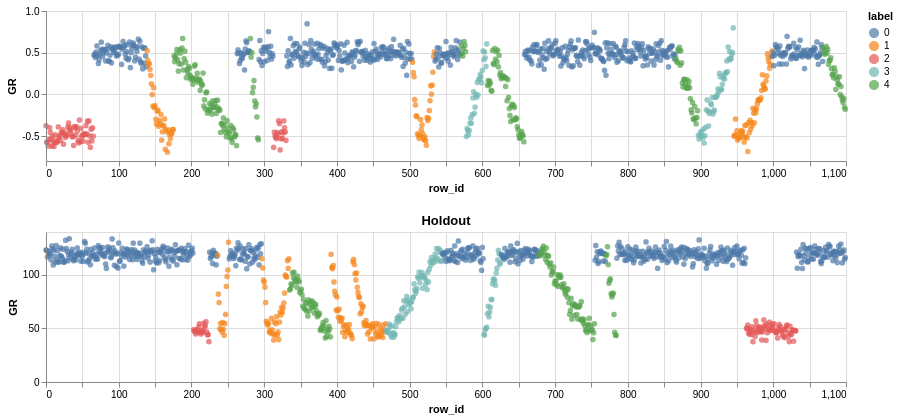

In [79]:
def rescale_X_to_maxmin(X,note='note'):
    print(f'Performing a rescale on {note}..')
    for i in range(X.shape[0]):
        top = np.quantile(X[i,:],0.72)
        bottom = 0.33 + 0.4*top
        new_row = (X[i,:] -bottom)/(top-bottom)-0.5
        X[i,:] = new_row
    return X

X, y = results[f'data_dict_train_{fold}']['X_fake_only'].copy(), results[f'data_dict_train_{fold}']['y_fake_only'].copy()

i = np.random.randint(0,200,1)[0]
#X = rescale_X_to_maxmin(X,note='fakes')
df_sub = pd.DataFrame({'row_id':np.arange(X.shape[1]),'GR':X[i,:][:,0],'label':np.argmax(y[i,:],axis=1) })
df_sub_ho = pd.DataFrame({'row_id':np.arange(X_ho.shape[1]),'GR':X_ho[i,:][:,0],'label':np.argmax(y_ho[i,:],axis=1) })

ch_gr = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
#ch_grp = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='pred:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()

ch_gr_ho = alt.Chart(df_sub_ho,height=150,width=800,title='Holdout').encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
#ch_grp = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='pred:N').mark_point(size=30,filled=True)
ch_lab_ho = alt.Chart(df_sub_ho,height=150,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()


#ch_pred = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='pred',order='row_id',color='pred:N').mark_point()
mu0 = df_sub[df_sub['label']==0]['GR'].median()
mu2 = df_sub[df_sub['label']==2]['GR'].median()

print(mu0,mu2)
ch_gr & ch_gr_ho

In [80]:
np.logical_not(np.isnan(X).any(axis=1))[:,0]

array([ True,  True,  True, ...,  True,  True,  True])

             row_id       well_id            GR         label
count  4.400000e+06  4.400000e+06  4.400000e+06  4.400000e+06
mean   5.495000e+02  1.999500e+03  9.759792e+01  1.177333e+00
std    3.175426e+02  1.154701e+03  3.206393e+01  1.464788e+00
min    0.000000e+00  0.000000e+00  1.947262e+01  0.000000e+00
25%    2.747500e+02  9.997500e+02  6.569258e+01  0.000000e+00
50%    5.495000e+02  1.999500e+03  1.075080e+02  0.000000e+00
75%    8.242500e+02  2.999250e+03  1.235464e+02  2.000000e+00
max    1.099000e+03  3.999000e+03  1.618695e+02  4.000000e+00


/home/geoanton/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


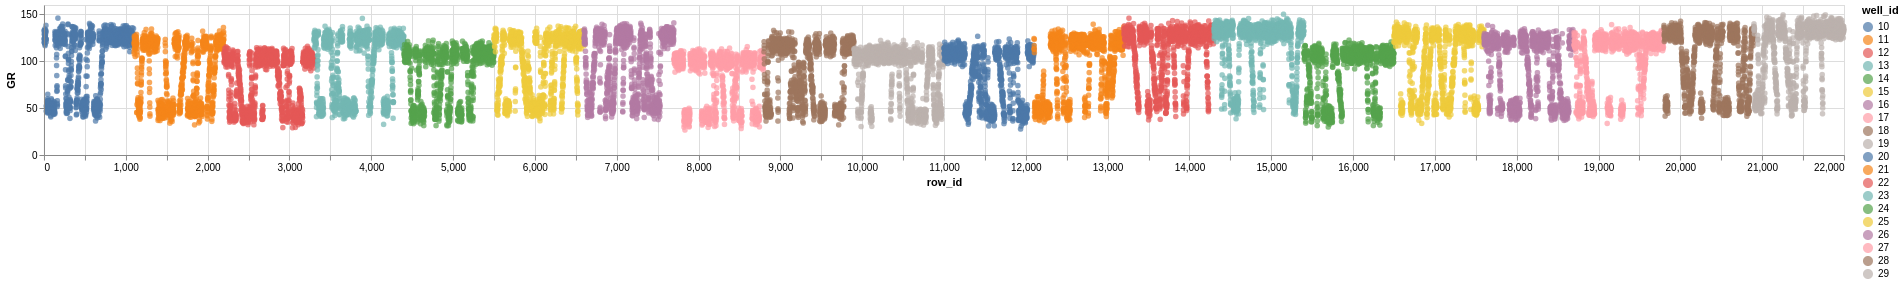

In [8]:
print(df_train.describe())
well_ids = df_train['well_id'].unique()[10:30]
df_sub = df_train[df_train['well_id'].isin(well_ids)]
df_sub['row_id'] = np.arange(df_sub.shape[0])
#df_sub['GR'] = (df_sub['GR']-df_sub['GR'].mean())/df_sub['GR'].std()

ch_gr = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR',order='row_id',color='well_id:N').mark_point(size=30,filled=True)
#ch_grp = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='pred:N').mark_point(size=30,filled=True)

#ch_pred = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='pred',order='row_id',color='pred:N').mark_point()

(ch_gr ) 

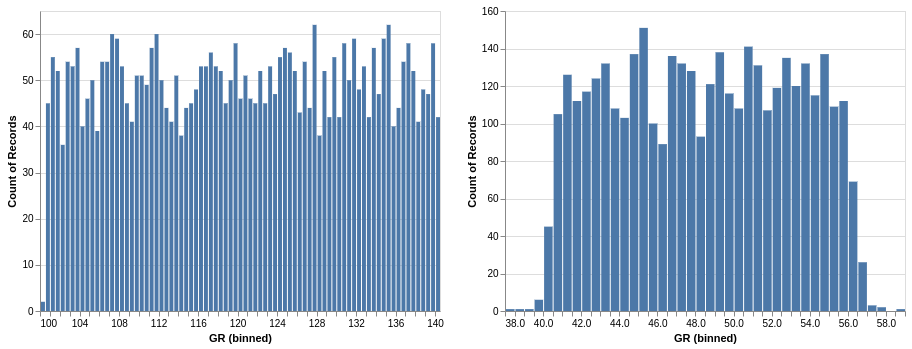

In [3]:
x0 = df_train[df_train['label']==0].groupby('well_id')['GR'].mean().to_frame()
x2 = df_train[df_train['label']==2].groupby('well_id')['GR'].mean().to_frame()

df_train_new = df_train.copy().join(x0.reset_index(),rsuffix='_0',on='well_id').drop(columns ='well_id_0')
df_train_new = df_train_new.join(x2.reset_index(),rsuffix='_2',on='well_id').drop(columns ='well_id_2')

c2 = alt.Chart(x2).encode(x=alt.X('GR',bin=alt.Bin(maxbins=100)),y='count()').mark_bar()
c0 =alt.Chart(x0).encode(x=alt.X('GR',bin=alt.Bin(maxbins=100)),y='count()').mark_bar()

c0 | c2 

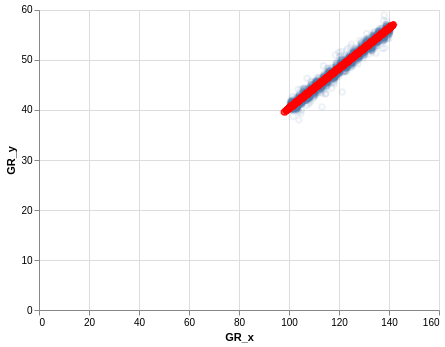

In [49]:
from sklearn.linear_model import RANSACRegressor

# For train
x_up = df_train.groupby('well_id')['GR'].quantile(0.72)
df_joint = pd.merge(x0.reset_index(),x2.reset_index(),on='well_id',how='right').dropna()
df_joint_fake = pd.DataFrame({'GR_x':x_up.values,'GR_y':0.4*x_up.values + 0.33})
ch_joint = alt.Chart(df_joint).encode(x='GR_x',y='GR_y').mark_point(opacity=0.1)
ch_joint_fake = alt.Chart(df_joint_fake).encode(x='GR_x',y='GR_y',color=alt.value('red')).mark_point(opacity=0.9)
lm = RANSACRegressor()
lm.fit(df_joint['GR_x'].values.reshape(-1,1),df_joint['GR_y'].values.reshape(-1,1))
ch_joint+ch_joint_fake


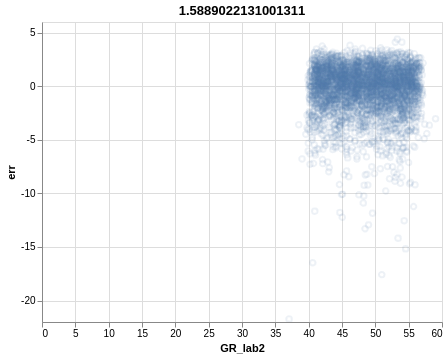

In [60]:
## Quantile to pick
x2 = df_train[df_train['label']==2].groupby('well_id')['GR'].median().to_frame()
x_up = df_train.groupby('well_id')['GR'].quantile(0.1).to_frame()
df_joint = pd.merge(x2.reset_index(),x_up.reset_index(),on='well_id',how='right',suffixes =['_lab2','_up']).dropna()
df_joint['err'] = df_joint['GR_lab2'] - df_joint['GR_up']
rmse = str(df_joint['err'].abs().mean())
ch_joint = alt.Chart(df_joint,title=rmse).encode(x='GR_lab2',y='err').mark_point(opacity=0.1)
ch_joint


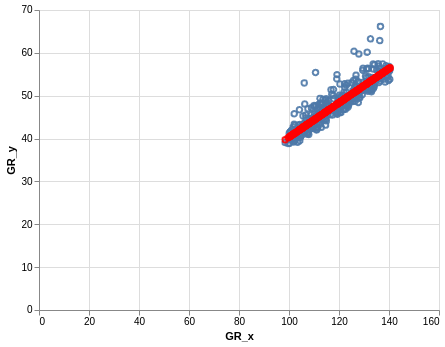

In [64]:
# For test
df_test = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')
x_up = df_test.groupby('well_id')['GR'].quantile(0.72)
x_down = df_test.groupby('well_id')['GR'].quantile(0.1)
df_joint = pd.merge(x_up.reset_index(),x_down.reset_index(),on='well_id',how='right',suffixes =['_x','_y']).dropna()
df_joint_fake = pd.DataFrame({'GR_x':x_up.values,'GR_y':0.4*x_up.values + 0.33})
ch_joint = alt.Chart(df_joint).encode(x='GR_x',y='GR_y').mark_point(opacity=0.9)
ch_joint_fake = alt.Chart(df_joint_fake).encode(x='GR_x',y='GR_y',color=alt.value('red')).mark_point(opacity=0.9)
ch_joint + ch_joint_fake


In [242]:
##### x0 = df_train[df_train['label']==0].groupby('well_id')['GR'].median()
well_ids = df_train['well_id'].sample(4,random_state=13).unique()

x0 = df_train[df_train['label']==0].groupby('well_id')['GR'].median()[well_ids].to_frame()
x2 = df_train[df_train['label']==2].groupby('well_id')['GR'].median()[well_ids].to_frame()

df_train_new = df_train[df_train['well_id'].isin(well_ids)]
df_train_new = pd.merge(df_train_new,x0.reset_index(),on='well_id',suffixes=('','_0'))#.drop(columns ='well_id_0')
df_train_new = pd.merge(df_train_new,x2.reset_index(),on='well_id',suffixes=('','_2'))#.drop(columns ='well_id_0')
df_train_new

row_id  well_id          GR  label        GR_0       GR_2
0          0     1401  116.443801      0  114.139582  46.743629
1          1     1401  108.069501      0  114.139582  46.743629
2          2     1401  109.032034      0  114.139582  46.743629
3          3     1401  116.127672      0  114.139582  46.743629
4          4     1401  109.509742      0  114.139582  46.743629
...      ...      ...         ...    ...         ...        ...
4395    1095     2905  136.198745      0  137.816364  55.733522
4396    1096     2905  137.287788      0  137.816364  55.733522
4397    1097     2905  137.973630      0  137.816364  55.733522
4398    1098     2905  131.373258      0  137.816364  55.733522
4399    1099     2905  139.552631      0  137.816364  55.733522

[4400 rows x 6 columns]

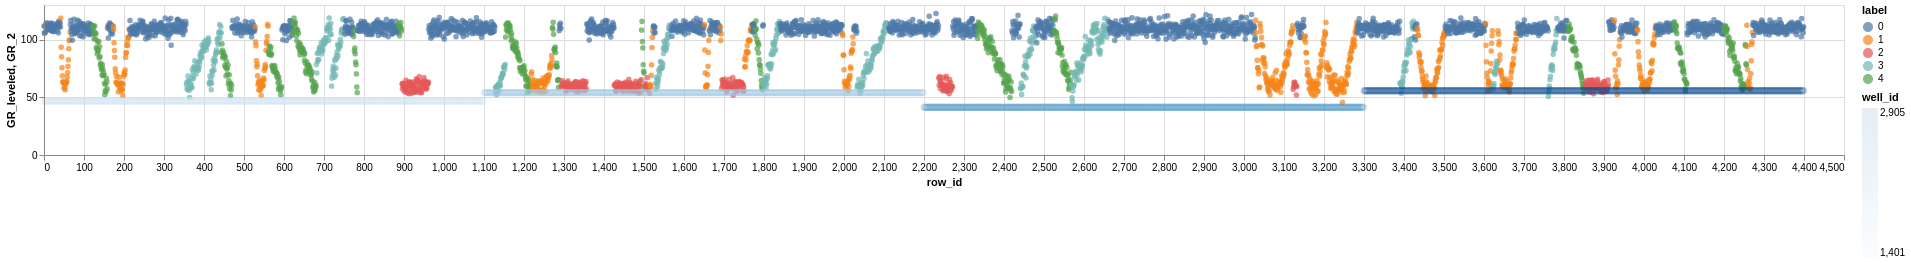

In [244]:
df_train_new['scale'] = (z0-z2)/(df_train_new['GR_0'] - df_train_new['GR_2'])

z0,z2=110,60
scale = (z0-z2)/(df_train_new['GR_0'] - df_train_new['GR_2'])

df_train_new['GR_leveled'] = (df_train_new['GR'] - df_train_new['GR_2'])*scale+z2

df_sub = df_train_new[df_train_new['well_id'].isin(well_ids)].copy()
df_sub['row_id'] = np.arange(df_sub.shape[0])

ch_gr = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR_leveled',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch20 = alt.Chart(df_sub,height =600,width=600).encode(x='row_id',y='GR_2',order='row_id',color='well_id').mark_point(size=30,opacity=0.1)
#ch20
ch_gr+ch20
#df_train_new[df_train_new['label']==2].groupby(['well_id'])['GR_leveled'].mean().plot()
#df_sub[df_sub['label']==2].groupby(['well_id'])['GR_leveled'].median()
#df_train[df_train['label']==0].groupby('well_id')['GR'].mean().to_frame()


In [177]:
df_train_new.to_pickle('../data/processed/df_normalized.pck')


In [178]:
%matplotlib inline

# Check the sliced data

/home/geoanton/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


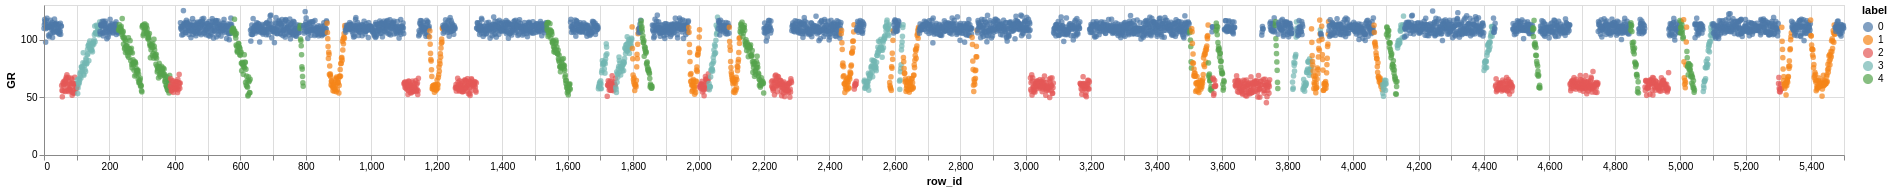

In [275]:
df_sliced = pd.read_pickle('../data/processed/sliced_well.pck')

well_ids = df_sliced['well_id'].sample(100).unique()[:5]
df_sub = df_sliced[df_sliced['well_id'].isin(well_ids)]
df_sub['row_id'] = np.arange(df_sub.shape[0])
#df_sub['GR'] = (df_sub['GR']-df_sub['GR'].mean())/df_sub['GR'].std()

ch_gr = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
#ch_grp = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='pred:N').mark_point(size=30,filled=True)
#ch_gr_g2 = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR',order='row_id').mark_point(size=30,filled=True)

#ch_pred = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='pred',order='row_id',color='pred:N').mark_point()
#mu0 = df_sub[df_sub['label']==2]['GR_leveled'].median()
ch_gr
#df_sub[df_sub['label']==0].groupby(['well_id'])['GR'].median()
#(ch_gr + ch_gr_g2 ) 

# Build a correlation matrix

In [27]:
a = df_test[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
a.columns = np.arange(a.shape[1])
b = df_test_cax[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
b.columns = np.arange(b.shape[1])+a.shape[1]+1
c = df_train[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
c.columns = np.arange(c.shape[1])+a.shape[1]+b.shape[1]+1
d = df_train_cax[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
d.columns = np.arange(d.shape[1])+a.shape[1]+b.shape[1]+c.shape[1]+1
all_df =pd.concat([a,b,c,d],axis=1)

In [113]:
%matplotlib inline
cm = np.corrcoef(all_df.values,rowvar=False)
for i in range(cm.shape[0]):
    cm[i,i] = 0
b = np.max(cm,axis=1)

In [60]:
from scipy.signal import medfilt
x = df_train[df_train['label']==4]['GR'].diff().values
np.nanstd(x)

12.818672373586598

## Figure out if the depth reference point is common, or tied to surface.
1. Looks like the reference is not globally defined, i.e. the 0 depth is at surface. :(
2. The wells have a consistent length (all have 1100 points). So maybe the geological model is flat-surfaced..?


In [121]:
df_train.groupby('well_id').size().describe()

count    4000.0
mean     1100.0
std         0.0
min      1100.0
25%      1100.0
50%      1100.0
75%      1100.0
max      1100.0
dtype: float64

Lets plot a few wells with close `well_id` together in a section

/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


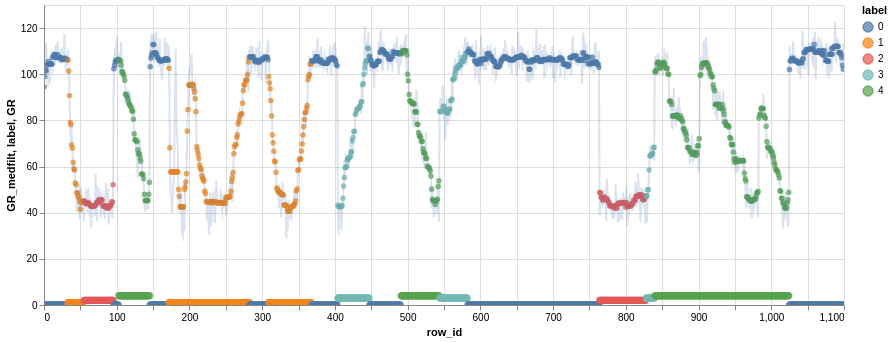

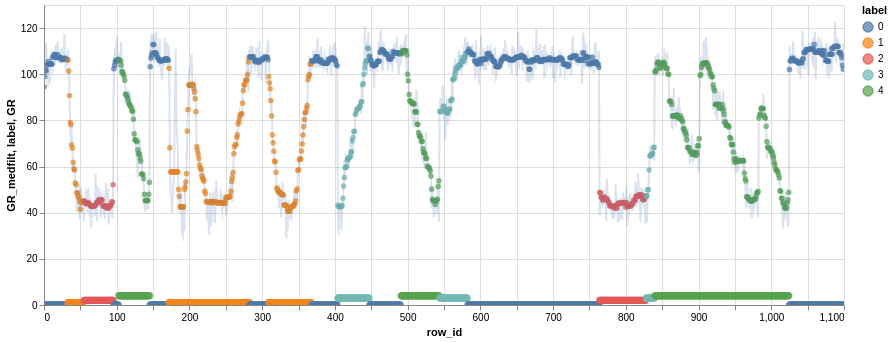

In [132]:
h=300
well_ids = df_train['well_id'].unique()[0]
df_sub = df_train[df_train['well_id'] == well_ids]
df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)
ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line

# Try playing with KDTree

In [67]:
from scipy.signal import medfilt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def cut_window(data_cycle, overlap=0.0, base_length=96):
    """
    Function for fancy numpy indexing
    :param data_cycle:
    :type data_cycle:
    :param overlap:
    :type overlap:
    :param base_length:
    :type base_length:
    :return:
    :rtype:
    """
    step = int((1 - overlap) * base_length)
    n_windows = np.ceil((data_cycle.shape[0] - base_length) / step)
    indexer = np.arange(base_length)[None, :] + step * np.arange(n_windows)[:, None]
    return indexer.astype('int'), int(n_windows)

def get_a_NN_object(df, n_wells_start, n_wells_end=2000, window_length=45):
    df['GR_medfilt'] = medfilt(df['GR'], 31)
    well_ids = df['well_id'].unique().tolist()[n_wells_start:(n_wells_start + n_wells_end)]
    df_wells = df[df['well_id'].isin(well_ids)]
    idxr, n_wins = cut_window(df_wells['GR_medfilt'], overlap=0.8, base_length=window_length)
    windows = df_wells['GR_medfilt'].values[idxr]
    labels = df_wells['label'].values[idxr]
    NN = NearestNeighbors(n_neighbors=10, metric='braycurtis')
    NN.fit(windows)
    return NN, labels


def augment_a_well_nearest_neighbors(df, NN, labels, bl=40):
    df_tmp = df.copy()
    df_tmp['GR_nn'] = medfilt(df['GR'], 31)
    idxr, n_win = cut_window(df_tmp['GR_nn'].values, overlap=0.0, base_length=bl)
    windows = df_tmp['GR_nn'].values[idxr]
    dist, idw = NN.kneighbors(windows, n_neighbors=5)
    dist_flip, idw_flip = NN.kneighbors(np.fliplr(windows), n_neighbors=5)

    pred = mode(labels[idw, :], axis=1)[0]
    pred = pred.reshape(pred.shape[0], pred.shape[2]).flatten()

    pred_lr = mode(labels[idw_flip, :], axis=1)[0]
    pred_lr = pred_lr.reshape(pred_lr.shape[0], pred_lr.shape[2])

    df_labels_windows = pd.DataFrame(
        {'row_id': idxr.flatten(), f'label_nn_{bl}': pred, f'flip_same_{bl}': np.equal(pred, pred_lr.flatten()),
         f'same_after_inv_{bl}': np.equal(pred, np.fliplr(pred_lr).flatten())})
    res = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df_tmp.join(res, on='row_id', rsuffix='_r').drop(columns=['row_id_r', 'GR_nn'])
    return res

df_train['GR_medfilt'] = medfilt(df_train['GR'],31)
window_length = 35

wells_test = df_train['well_id'].unique()[3900:3950]
df_wells_test =  df_train[df_train['well_id'].isin(wells_test)]
NN_list,labels_list = [],[]
NN, labels = get_a_NN_object(df_train,n_wells_start=0,n_wells_end=400,window_length=window_length)


df_wells_test_dict  = dict(zip(wells_test,[df_train[df_train['well_id'] ==w] for w in wells_test]))
df_wells_test_augmented =[augment_a_well_nearest_neighbors(df,NN,labels,bl=window_length) for df in df_wells_test_dict.values()]

In [68]:
df_all_test = pd.concat(df_wells_test_augmented,axis=0).dropna()
print(accuracy_score(df_all_test['label'],df_all_test[f'label_nn_{window_length}']))

0.8731981566820276


0.89096


[[   0    1    2 ...   32   33   34]
 [  35   36   37 ...   67   68   69]
 [  70   71   72 ...  102  103  104]
 ...
 [ 980  981  982 ... 1012 1013 1014]
 [1015 1016 1017 ... 1047 1048 1049]
 [1050 1051 1052 ... 1082 1083 1084]]
(31, 35)


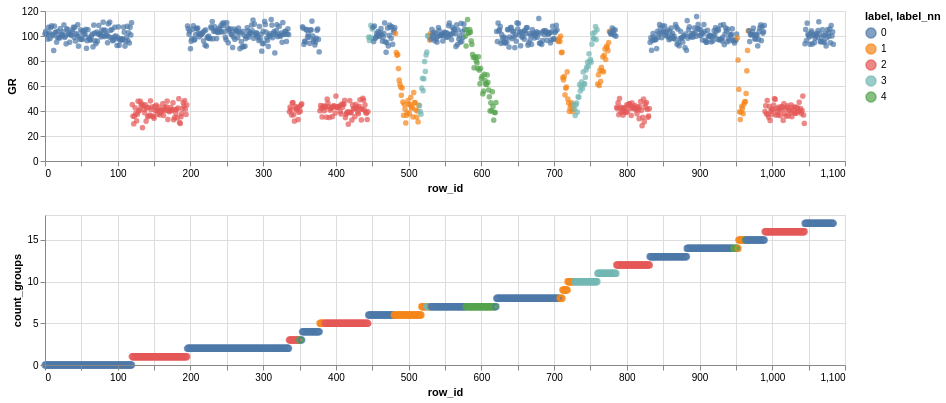

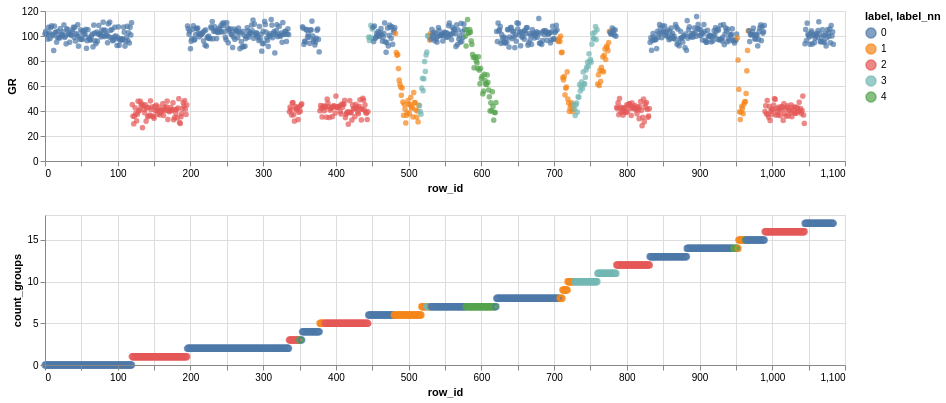

In [117]:
%matplotlib inline
tmp = df_train[df_train['well_id'].isin([17])]
def augment_a_well_nearest_neighbors(df,NN,labels,bl=50):
    from scipy.stats import mode
    idxr,n_win = cut_window(df['GR_medfilt'].values,overlap=0.0,base_length=bl)
    windows = df['GR_medfilt'].values[idxr]
    print(idxr)
    dist,idw = NN.kneighbors(windows,n_neighbors=5)
    pred =mode(labels[idw,:],axis=1)[0]
    pred = pred.reshape(pred.shape[0],pred.shape[2])
    print(pred.shape)
    #true_labels = df['label'].values[idxr].flatten()
    res=None
    df_labels_windows = pd.DataFrame({'row_id':idxr.flatten(),'label_nn':pred.flatten()})
    #df_labels_windows = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df.copy().join(res,on='row_id',rsuffix='_r').drop(columns = 'row_id_r')
    return res


def divide_block_steps(df,t=24):
    df['step'] = (df['GR'].diff().abs() >= t)
    df_steps = df[df['step']]
    
    inds = np.hstack([0,np.array(df_steps['row_id']),df['row_id'].max()+1])
    counts = np.zeros(df.shape[0])
    counts[:inds[0]] = np.arange(inds[0])
    res = np.ones(df.shape[0])
    for i in range(len(inds) - 1):
        res[inds[i]:inds[i + 1]] = i
        counts[inds[i]:inds[i + 1]] = np.arange(inds[i + 1] - inds[i])
    
    df['prev_val_step'] = np.nan
    df.loc[df['step'],'prev_val_step'] = df['GR'].diff()
    df['prev_val_step'] = df['prev_val_step'].fillna(method = 'ffill').astype('float')
    
    df['next_val_step'] = np.nan
    df.loc[df['step'],'next_val_step'] = df['GR'].diff()
    df['next_val_step'] = df['next_val_step'].fillna(method ='bfill').astype('float')    
        
    df['count_step'] = counts
    df['count_groups'] = res
    df['count_step_norm'] = df['count_step']/df.groupby('count_groups')['count_step'].transform('max')
    
    return df

df_preds = augment_a_well_nearest_neighbors(tmp,NN,labels,bl=window_length).dropna()
df_preds['grp'] = (df_preds['label_nn']==df_preds['label_nn'].shift(1)).cumsum()
df_preds = divide_block_steps(df_preds,20)

ch_gr = alt.Chart(df_preds,height=150,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_preds,height=150,width=800).encode(x='row_id',y='count_groups',order='row_id',color='label_nn:N').mark_point()
#ch_steps = alt.Chart(df_steps,height=150,width=800).encode(x='row_id').mark_rule()

(ch_gr) & (ch_lab)

In [72]:
df_preds

row_id  well_id          GR  label  GR_medfilt  label_nn   grp
3630000       0     3300  120.201097      0  109.949728       0.0     0
3630001       1     3300  117.084173      0  109.949728       0.0     1
3630002       2     3300  114.449990      0  109.949728       0.0     2
3630003       3     3300  120.566324      0  109.949728       0.0     3
3630004       4     3300  117.823130      0  109.949728       0.0     4
...         ...      ...         ...    ...         ...       ...   ...
3631045    1045     3300  111.180124      0  113.994824       0.0  1023
3631046    1046     3300  117.882394      0  114.425304       0.0  1024
3631047    1047     3300  116.581583      0  115.459260       0.0  1025
3631048    1048     3300  113.994824      0  115.459260       0.0  1026
3631049    1049     3300  108.189680      0  115.459260       0.0  1027

[1050 rows x 7 columns]

# Prototype a few functions:

In [6]:
from sklearn.linear_model import LinearRegression
def diff_sum(x):
    res = np.diff(x).sum()
    return res
def abs_diff_sum(x):
    res = np.abs(np.diff(x)).sum()
    return res

def rolling_slope(x):
    model_ols =LinearRegression()
    idx=np.arange(x.shape[0])
    model_ols.fit(idx.reshape(-1, 1), x.reshape(-1, 1))
    res = model_ols.coef_[0]
    return res

    
def apply_rolling_functions(df,col='GR',window=10,func ={'mean':np.mean,'std':np.std,'diff_sum':diff_sum,'abs_diff_sum':abs_diff_sum,'slope':rolling_slope}):
    names =[]
    for k,v in func.items():
        series = df[col].rolling(window=window,center=True,min_periods=1).apply(v,raw=True)
        colname = f'{k}_{window}_{col}'
        df.loc[:,colname] = series.values
        names.append(colname)
    df.index = np.arange(df.shape[0])
    return df[names]
def preprocess_a_well(df_well):
    df_feats_w20 = apply_rolling_functions(df_well,window=20)
    df_feats_w60 = apply_rolling_functions(df_well,window=60)
    df_feats_w150 = apply_rolling_functions(df_well,window=150)
    df_feats = pd.concat([df_well,df_feats_w20,df_feats_w60,df_feats_w150],axis=1)
    return df_feats
